# Convolutional Variational AutoEncoder for classification

Note: this is a slight modification of the F.Chollet VAE example (https://keras.io/examples/generative/vae/) to add classification restrictions in the loss function.

## Setup


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback, TensorBoard
import matplotlib.pyplot as plt
import math

## Create a sampling layer


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the encoder


In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## Build the classifier

In [ ]:
n_classes = 10
latent_dim = 2

clf_latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling_clf')
#clf_intermediate = layers.Dense(200, activation='relu')(clf_latent_inputs)
#clf_outputs = layers.Dense(n_classes, activation='softmax', name='class_output')(clf_intermediate)
clf_outputs = layers.Dense(n_classes, activation='softmax', name='class_output')(clf_latent_inputs)
# Instantiate the classifier model:
classifier = keras.Model(clf_latent_inputs, clf_outputs, name='clf')
classifier.summary()

Model: "clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling_clf (InputLayer)  [(None, 2)]               0         
_________________________________________________________________
class_output (Dense)         (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


## Build the decoder


In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## Define the VAE as a `Model` with a custom `train_step`


In [ ]:
class VAE(keras.Model):

    def __init__(self, encoder, decoder, clf, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.clf = clf

    def train_step(self, data):
        x, target_x = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(x)
            # Reconstruction
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(x, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            # kl loss
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            # Classifier
            clf_prediction = classifier(z)
            clf_loss = tf.reduce_mean(
                keras.losses.categorical_crossentropy(target_x, clf_prediction)
            )
            clf_loss *= 0.5

            # If fit method is used instead of train_step, the weigths can be set with the "loss_weights" argument in compile
            total_loss = weight_vae*(reconstruction_loss + kl_loss) + weight_clf*clf_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "clf_loss": clf_loss,
        }

## Initialize the VAE model


In [ ]:
(x_train, target_train), (x_test, target_test) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255
# Convert to one-hot encoding
target_train = np.eye(n_classes)[target_train]

vae = VAE(encoder, decoder, classifier)
vae.compile(optimizer=keras.optimizers.Adam())

model_callbacks = [
  EarlyStopping(monitor='loss', mode='min', verbose=1, patience=30)
]

## Finding the optimun LR

In [ ]:
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

Epoch 1/5
118/118 [==============================] - 2s 19ms/step - loss: 639.4139 - reconstruction_loss: 541.7992 - kl_loss: 5.7717e-04 - clf_loss: 1.2202
Epoch 2/5
118/118 [==============================] - 2s 19ms/step - loss: 628.7472 - reconstruction_loss: 532.1105 - kl_loss: 0.0038 - clf_loss: 1.2079
Epoch 3/5
118/118 [==============================] - 2s 19ms/step - loss: 367.0694 - reconstruction_loss: 273.1276 - kl_loss: 1.8697 - clf_loss: 1.1509
Epoch 4/5
118/118 [==============================] - 2s 19ms/step - loss: 255.4786 - reconstruction_loss: 178.4014 - kl_loss: 3.4969 - clf_loss: 0.9198
Epoch 5/5
118/118 [==============================] - 2s 18ms/step - loss: 212.9615 - reconstruction_loss: 167.7013 - kl_loss: 6.2955 - clf_loss: 0.4871


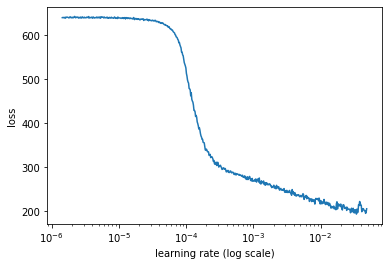

In [ ]:
lr_finder = LRFinder(vae)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(x_train, target_train, start_lr=0.000001, end_lr=0.05, batch_size=512, epochs=5)

# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

## Train the model

In [ ]:
vae.compile(optimizer=keras.optimizers.Adam(lr=0.0001))
history = vae.fit(x_train, target_train, epochs=500, batch_size=128, callbacks=model_callbacks)

Epoch 1/500
469/469 [==============================] - 4s 8ms/step - loss: 373.4848 - reconstruction_loss: 280.2488 - kl_loss: 1.9540 - clf_loss: 1.1410
Epoch 2/500
469/469 [==============================] - 4s 8ms/step - loss: 270.1786 - reconstruction_loss: 186.2667 - kl_loss: 2.8080 - clf_loss: 1.0138
Epoch 3/500
469/469 [==============================] - 4s 8ms/step - loss: 255.7380 - reconstruction_loss: 175.1163 - kl_loss: 3.2473 - clf_loss: 0.9672
Epoch 4/500
469/469 [==============================] - 4s 8ms/step - loss: 246.3274 - reconstruction_loss: 169.3877 - kl_loss: 3.8829 - clf_loss: 0.9132
Epoch 5/500
469/469 [==============================] - 4s 8ms/step - loss: 238.9201 - reconstruction_loss: 166.2297 - kl_loss: 4.4952 - clf_loss: 0.8524
Epoch 6/500
469/469 [==============================] - 4s 8ms/step - loss: 232.7438 - reconstruction_loss: 164.3438 - kl_loss: 5.1295 - clf_loss: 0.7909
Epoch 7/500
469/469 [==============================] - 4s 8ms/step - loss: 227.147

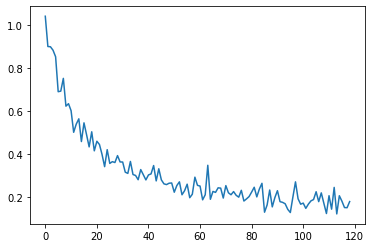

In [ ]:
plt.plot(history.history['clf_loss'])
plt.show()

## Display a grid of sampled digits


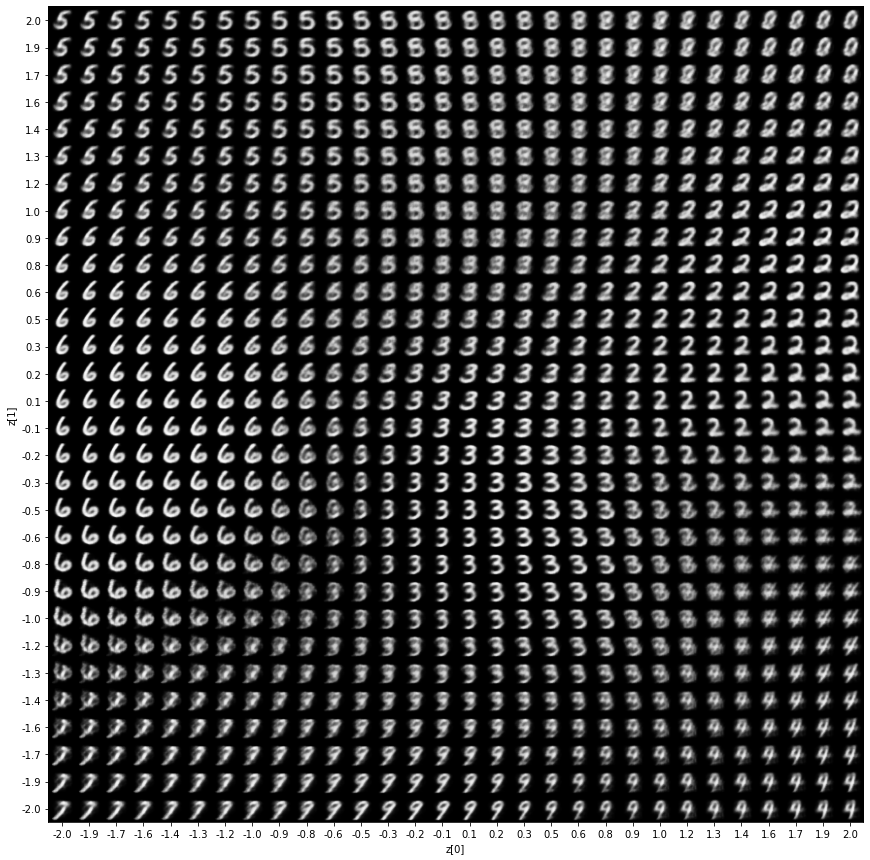

In [ ]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # Display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # Linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

## Display how the latent space clusters different digit classes


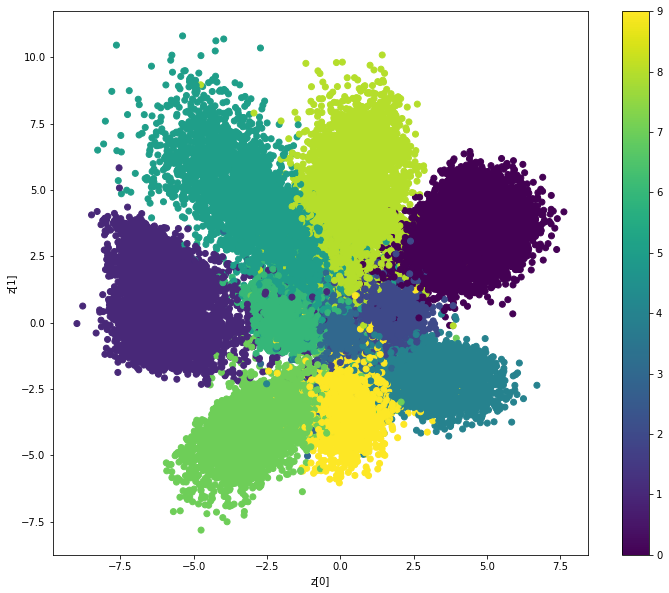

In [ ]:

def plot_label_clusters(encoder, decoder, data, labels):
    # Display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)